In [1]:
import sys; sys.path.append("..")
from policies import max_min_fairness, max_min_fairness_strategy_proof
import utils

from strategy_proofness_tests import test_strategy_proofness
import copy
import random
import time

import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [2]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

## Examples of vanilla policy violating strategy-proofness

In [3]:
def print_allocation_analysis(honest_throughputs, dishonest_throughputs,
                              strategy_proof_allocations, non_strategy_proof_allocations):
    print("=" * 100)
    print("Honest throughputs:", np.array(honest_throughputs))
    print("Dishonest throughputs:", np.array(dishonest_throughputs))
    print("-" * 100)

    for allocations, allocation_str in zip(
        [strategy_proof_allocations, non_strategy_proof_allocations],
        ["Strategy-proof", "Not strategy-proof"]):
        for allocation, throughput_str in zip(allocations,
                                              ["Honest throughputs", "Dishonest throughputs"]):

            print("%s (%s)\n" % (allocation_str, throughput_str))
            effective_throughputs = np.sum(np.multiply(np.array(honest_throughputs), allocation),
                                           axis=1)
            print("Allocation:", allocation)
            print("Effective throughputs:", effective_throughputs)
            print("-" * 100)

In [4]:
def harness(honest_throughputs, dishonest_throughputs,
            worker_types, cluster_spec):  
    strategy_proof_allocations = []
    non_strategy_proof_allocations = []
    for (throughputs, experiment_string) in zip(
        [honest_throughputs, dishonest_throughputs],
        ["Allocation computed using true throughputs",
         "Allocation computed using dishonest throughputs"]):

        throughputs = np.array(throughputs)
        unflattened_throughputs = {
            i: {worker_types[j]: throughputs[i][j] for j in range(len(worker_types))}
            for i in range(len(throughputs))
        }
        unflattened_strategy_proof_allocation, discount_factors, \
            unflattened_non_strategy_proof_allocation, _, _ = \
                test_strategy_proofness(unflattened_throughputs, cluster_spec, verbose=False)
        strategy_proof_allocation = np.zeros((len(throughputs), len(cluster_spec)))
        non_strategy_proof_allocation = np.zeros((len(throughputs), len(cluster_spec)))
        for i in range(len(throughputs)):
            for j in range(len(worker_types)):
                strategy_proof_allocation[i][j] = \
                    unflattened_strategy_proof_allocation[i][worker_types[j]]
                non_strategy_proof_allocation[i][j] = \
                    unflattened_non_strategy_proof_allocation[i][worker_types[j]]

        strategy_proof_allocations.append(strategy_proof_allocation)
        non_strategy_proof_allocations.append(non_strategy_proof_allocation)

    effective_throughputs_honest_and_non_strategy_proof_allocation = \
        np.sum(np.multiply(honest_throughputs,
                           non_strategy_proof_allocations[0]), axis=1)
    effective_throughputs_dishonest_and_non_strategy_proof_allocation = \
        np.sum(np.multiply(honest_throughputs,
                           non_strategy_proof_allocations[1]), axis=1)
    effective_throughputs_honest_and_strategy_proof_allocation = \
        np.sum(np.multiply(honest_throughputs,
                           strategy_proof_allocations[0]), axis=1)
    effective_throughputs_dishonest_and_strategy_proof_allocation = \
        np.sum(np.multiply(honest_throughputs,
                           strategy_proof_allocations[1]), axis=1)

    if (effective_throughputs_honest_and_strategy_proof_allocation[0] /
           effective_throughputs_dishonest_and_strategy_proof_allocation[0] < 0.99):
        print("WARNING: Strategy-proof allocation is not actually strategy-proof!")
        print_allocation_analysis(honest_throughputs, dishonest_throughputs,
                                  strategy_proof_allocations, non_strategy_proof_allocations)
        return

    if (effective_throughputs_honest_and_non_strategy_proof_allocation[0] >=
        effective_throughputs_dishonest_and_non_strategy_proof_allocation[0]):
        return

    print("SUCCESS: Strategy-proof allocation is actually strategy-proof!")
    print_allocation_analysis(honest_throughputs, dishonest_throughputs,
                              strategy_proof_allocations, non_strategy_proof_allocations)

In [5]:
random.seed(42)
worker_types = ['v100', 'p100', 'k80']
cluster_spec = {'v100': 1, 'p100': 1, 'k80': 1}

for i in range(10):
    # throughputs specified in the above order.
    honest_throughputs = []
    for j in range(3):
        honest_throughputs.append(sorted([random.random(), random.random(), random.random()],
                                         reverse=True))
    dishonest_throughputs = copy.copy(honest_throughputs)
    dishonest_throughputs[0] = [random.random(), random.random(), random.random()]

    harness(honest_throughputs, dishonest_throughputs,
            worker_types, cluster_spec)

SUCCESS: Strategy-proof allocation is actually strategy-proof!
Honest throughputs: [[0.65  0.199 0.027]
 [0.589 0.545 0.22 ]
 [0.809 0.806 0.006]]
Dishonest throughputs: [[0.698 0.34  0.155]
 [0.589 0.545 0.22 ]
 [0.809 0.806 0.006]]
----------------------------------------------------------------------------------------------------
Strategy-proof (Honest throughputs)

Allocation: [[0.401 0.    0.1  ]
 [0.154 0.039 0.575]
 [0.    0.437 0.023]]
Effective throughputs: [0.263 0.238 0.353]
----------------------------------------------------------------------------------------------------
Strategy-proof (Dishonest throughputs)

Allocation: [[0.387 0.    0.203]
 [0.252 0.    0.48 ]
 [0.    0.467 0.   ]]
Effective throughputs: [0.257 0.254 0.376]
----------------------------------------------------------------------------------------------------
Not strategy-proof (Honest throughputs)

Allocation: [[0.475 0.    0.525]
 [0.525 0.261 0.214]
 [0.    0.739 0.261]]
Effective throughputs: [0.322 0

In [6]:
# Case: job 1 slower on one resource than everyone else.
# Lying about having higher throughput on that resource
# will give higher ET with non-SP allocation.
honest_throughputs = [[3, 1, 1],
                      [3, 2, 1],
                      [3, 2, 1]]
dishonest_throughputs = [[3, 1.1, 1],
                         [3, 2, 1],
                         [3, 2, 1]]
harness(honest_throughputs, dishonest_throughputs,
        worker_types, cluster_spec)

SUCCESS: Strategy-proof allocation is actually strategy-proof!
Honest throughputs: [[3 1 1]
 [3 2 1]
 [3 2 1]]
Dishonest throughputs: [[3.  1.1 1. ]
 [3.  2.  1. ]
 [3.  2.  1. ]]
----------------------------------------------------------------------------------------------------
Strategy-proof (Honest throughputs)

Allocation: [[0.32  0.    0.32 ]
 [0.164 0.339 0.164]
 [0.169 0.328 0.169]]
Effective throughputs: [1.28  1.333 1.333]
----------------------------------------------------------------------------------------------------
Strategy-proof (Dishonest throughputs)

Allocation: [[0.32  0.    0.32 ]
 [0.163 0.34  0.163]
 [0.17  0.327 0.17 ]]
Effective throughputs: [1.28  1.333 1.333]
----------------------------------------------------------------------------------------------------
Not strategy-proof (Honest throughputs)

Allocation: [[0.382 0.    0.618]
 [0.309 0.5   0.191]
 [0.309 0.5   0.191]]
Effective throughputs: [1.765 2.118 2.118]
------------------------------------------

In [7]:
honest_throughputs = [[3, 2, 0.9],
                      [3, 2, 1.1],
                      [3, 2, 1.1]]
dishonest_throughputs = [[3, 2, 1],
                         [3, 2, 1.1],
                         [3, 2, 1.1]]
harness(honest_throughputs, dishonest_throughputs,
        worker_types, cluster_spec)

SUCCESS: Strategy-proof allocation is actually strategy-proof!
Honest throughputs: [[3.  2.  0.9]
 [3.  2.  1.1]
 [3.  2.  1.1]]
Dishonest throughputs: [[3.  2.  1. ]
 [3.  2.  1.1]
 [3.  2.  1.1]]
----------------------------------------------------------------------------------------------------
Strategy-proof (Honest throughputs)

Allocation: [[0.022 0.639 0.   ]
 [0.32  0.01  0.331]
 [0.319 0.012 0.33 ]]
Effective throughputs: [1.345 1.345 1.345]
----------------------------------------------------------------------------------------------------
Strategy-proof (Dishonest throughputs)

Allocation: [[0.022 0.639 0.   ]
 [0.32  0.011 0.331]
 [0.32  0.011 0.331]]
Effective throughputs: [1.345 1.345 1.345]
----------------------------------------------------------------------------------------------------
Not strategy-proof (Honest throughputs)

Allocation: [[0.    0.989 0.011]
 [0.5   0.006 0.494]
 [0.5   0.006 0.494]]
Effective throughputs: [1.988 2.055 2.055]
------------------------

In [8]:
honest_throughputs = [[2.5, 2, 1],
                      [3, 2, 1],
                      [3, 2, 1]]
dishonest_throughputs = [[2.6, 2, 1],
                         [3, 2, 1],
                         [3, 2, 1]]
harness(honest_throughputs, dishonest_throughputs,
        worker_types, cluster_spec)

SUCCESS: Strategy-proof allocation is actually strategy-proof!
Honest throughputs: [[2.5 2.  1. ]
 [3.  2.  1. ]
 [3.  2.  1. ]]
Dishonest throughputs: [[2.6 2.  1. ]
 [3.  2.  1. ]
 [3.  2.  1. ]]
----------------------------------------------------------------------------------------------------
Strategy-proof (Honest throughputs)

Allocation: [[0.    0.64  0.   ]
 [0.333 0.    0.333]
 [0.333 0.    0.333]]
Effective throughputs: [1.28  1.333 1.333]
----------------------------------------------------------------------------------------------------
Strategy-proof (Dishonest throughputs)

Allocation: [[0.    0.64  0.   ]
 [0.333 0.    0.333]
 [0.333 0.    0.333]]
Effective throughputs: [1.28  1.333 1.333]
----------------------------------------------------------------------------------------------------
Not strategy-proof (Honest throughputs)

Allocation: [[0.    0.886 0.114]
 [0.5   0.057 0.443]
 [0.5   0.057 0.443]]
Effective throughputs: [1.886 2.057 2.057]
------------------------

## Runtimes

In [9]:
def generate_throughputs(num_jobs,
                         cluster_spec,
                         oracle_throughputs,
                         seed):
    rng = random.Random()
    rng.seed(seed)
    throughputs = {}
    for job_id in range(num_jobs):
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng)
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
    return throughputs

In [10]:
def get_runtimes():
    oracle_throughputs = utils.read_all_throughputs_json_v2("../simulation_throughputs.json")
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }    
    policy_to_label = {
        'max_min_fairness_perf': 'Vanilla',
        'max_min_fairness_strategy_proofness_perf': 'With SP'
    }
    for num_jobs in [4, 8, 16, 32]:
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(3):
            unflattened_throughputs = generate_throughputs(num_jobs, cluster_spec,
                                                           oracle_throughputs, seed=i)
            _, _, _, strategy_proof_runtime, non_strategy_proof_runtime = \
                test_strategy_proofness(unflattened_throughputs, cluster_spec, verbose=False)
            for (policy_label, runtime) in zip(['Vanilla', 'With SP'],
                                               [non_strategy_proof_runtime, strategy_proof_runtime]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

In [11]:
def plot_runtimes(data):
    plt.figure(figsize=(4.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='num_jobs', y='runtimes', style='policy',
                 hue='policy',
                 data=data, ci=None,
                 markers=True)
    ax.set_xlabel("Number of jobs")
    ax.set_ylabel("Seconds")
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.set_xticks([4, 8, 16, 32])
    ax.set_xticklabels([4, 8, 16, 32])
    ax.set_xlim([4, 32])
    ax.set_yticks([2**-8, 2**4])
    ax.set_yticks([2**-8, 2**-4, 1, 2**4])
    ax.set_yticklabels([0.004, 0.0625, 1, 16])
    sns.despine()

    leg = plt.legend(loc='upper left', frameon=False)

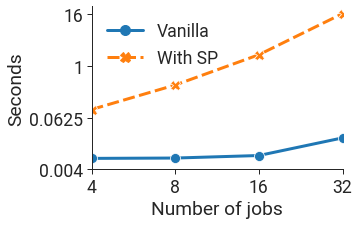

In [12]:
plot_runtimes(get_runtimes())

## Throughput reductions

In [16]:
def get_throughput_reduction():
    oracle_throughputs = utils.read_all_throughputs_json_v2("../simulation_throughputs.json")
    data = {
        'num_jobs': [],
        'effective_throughput_reductions': [],
        'style': []
    }    
    policy_to_label = {
        'max_min_fairness_perf': 'Vanilla',
        'max_min_fairness_strategy_proofness_perf': 'With SP'
    }
    for num_jobs in [4, 8, 16, 32]:
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(3):
            unflattened_throughputs = generate_throughputs(num_jobs, cluster_spec,
                                                           oracle_throughputs, seed=i)
            strategy_proof_allocation, _, non_strategy_proof_allocation, _, _ = \
                test_strategy_proofness(unflattened_throughputs, cluster_spec, verbose=False)
            total_effective_throughputs = []
            for allocation in [non_strategy_proof_allocation,
                               strategy_proof_allocation]:
                total_effective_throughput = 0.0
                for job_id in allocation:
                    for worker_type in allocation[job_id]:
                        total_effective_throughput += (allocation[job_id][worker_type] *
                                                       unflattened_throughputs[job_id][worker_type])
                total_effective_throughputs.append(total_effective_throughput)
            data['num_jobs'].append(num_jobs)
            data['effective_throughput_reductions'].append(
                total_effective_throughputs[1] / total_effective_throughputs[0])
            data['style'].append('style')
    return data

In [17]:
def plot_throughput_reductions(data):
    plt.figure(figsize=(4.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='num_jobs', y='effective_throughput_reductions',
                 style='style', hue='style',
                 data=data, ci=None,
                 markers=True, legend=False)
    ax.set_xlabel("Number of jobs")
    ax.set_ylabel("Effective throughput\nreduction")
    ax.set_xscale('log', basex=2)
    ax.set_xticks([4, 8, 16, 32])
    ax.set_xticklabels([4, 8, 16, 32])
    ax.set_xlim([4, 32])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_ylim([0, 1])
    sns.despine()

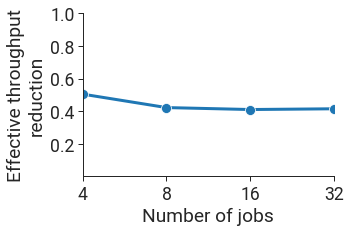

In [18]:
plot_throughput_reductions(get_throughput_reduction())